In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Read dataset
df = pd.read_csv(r'C:\Users\theha\OneDrive\Desktop\Projects\Mini_Project_Missing_Values\Problem_2_MAR\P2_MAR_Patient Records.csv')

# Screen data structure
df.head()

,patient_id,age,gender,bmi,smoker,blood_pressure,cholesterol,disease
0,1,58,M,26.3,Yes,152,267.715948,0
1,2,71,M,17.3,No,121,NaN,1
2,3,48,M,27.8,No,120,295.233264,0
3,4,34,F,26.9,Yes,105,205.467218,0
4,5,62,F,20.3,No,105,NaN,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   patient_id      200 non-null    int64  
 1   age             200 non-null    int64  
 2   gender          200 non-null    object 
 3   bmi             200 non-null    float64
 4   smoker          200 non-null    object 
 5   blood_pressure  200 non-null    int64  
 6   cholesterol     168 non-null    float64
 7   disease         200 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 12.6+ KB


In [5]:
# Count Missing Value
n_missing = df.isna().sum()

# CalculCalculate % missing value
pct_missing = df.isna().mean()*100

# Dataframe for 2 series
audit = pd.DataFrame({
    'n_missing': n_missing,
    'pct_missing': pct_missing.round(2)
})

# Sort by DESC
audit = audit.sort_values('pct_missing', ascending=False)

audit

,n_missing,pct_missing
cholesterol,32,16.0
patient_id,0,0.0
gender,0,0.0
age,0,0.0
bmi,0,0.0
smoker,0,0.0
blood_pressure,0,0.0
disease,0,0.0


In [9]:
# Create flag missing cholesterol
df['_chol_missing'] = df['cholesterol'].isna().astype(int)

# Create BMI group
bins = [0, 18.5, 25, 30, 35, 100]
labels = ['under', 'normal', 'over', 'obese_I', 'obese_II+']
df['bmi_grp'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=False)

# Calculate missing cholesterol by each group
# by BMI
miss_by_bmi = df.groupby('bmi_grp')['_chol_missing'].mean()
print("The percentage of missing by BMI:")
print(miss_by_bmi.round(3))
print("------")

# by Smoking
miss_by_smoke = df.groupby('smoker')['_chol_missing'].mean()
print("The percentage of missing by smoke:")
print(miss_by_smoke.round(3))
print("------")

# by Gender
miss_by_gender = df.groupby('gender')['_chol_missing'].mean()
print("The percentage of missing by Gender:")
print(miss_by_gender.round(3))

The percentage of missing by BMI:
bmi_grp
under        0.111
normal       0.098
over         0.090
obese_I      0.314
obese_II+    0.412
Name: _chol_missing, dtype: float64
------
The percentage of missing by smoke:
smoker
No     0.162
Yes    0.155
Name: _chol_missing, dtype: float64
------
The percentage of missing by Gender:
gender
F    0.151
M    0.170
Name: _chol_missing, dtype: float64


**Missing Data Analysis – Cholesterol**

We analyzed the proportion of missing cholesterol values across BMI categories, smoking status, and gender.

* By BMI group, the missingness rate increases sharply with obesity: underweight (11.1%), normal (9.8%), overweight (9.0%), obese I (31.4%), obese II+ (41.2%). This suggests that cholesterol missingness is not random and may be systematically related to higher BMI.

* By smoking status, the difference between non-smokers (16.2%) and smokers (15.5%) is negligible. Smoking does not appear to drive missingness.

* By gender, females (17.0%) show slightly higher missingness compared to males (15.1%), but the difference is modest.

**Conclusion:** The strong relationship between missingness and BMI indicates the data is likely not Missing Completely At Random (MCAR). Further imputation or sensitivity analysis should account for BMI to reduce potential bias.

In [13]:
import statsmodels.api as sm

# 0) Choose neccessary cols and create copy
cols_num  = ['bmi', 'age', 'blood_pressure']
cols_cat  = ['smoker', 'gender']
target    = '_chol_missing'
use_cols  = cols_num + cols_cat + [target]
data = df[use_cols].copy()

# Coerce numeric columns (if there are mixed characters, it will become NaN)
for c in cols_num:
    data[c] = pd.to_numeric(data[c], errors='coerce')

# Make sure target is binary number
data[target] = pd.to_numeric(data[target], errors='coerce').astype('Int64')

# Eliminate missing rows after casting
data = data.dropna(subset=cols_num + [target])

# Encode categorical variable → numeric; cast dtype=float to avoid object
X = pd.get_dummies(data[cols_num + cols_cat],
                   drop_first=True,
                   dtype=float)

# Add constants
X = sm.add_constant(X)

# Get y (0/1); cast to int or float
y = data[target].astype(int)

# Fit Logit
model = sm.Logit(y, X, missing='drop').fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.394668
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          _chol_missing   No. Observations:                  200
Model:                          Logit   Df Residuals:                      194
Method:                           MLE   Df Model:                            5
Date:                Wed, 03 Sep 2025   Pseudo R-squ.:                  0.1024
Time:                        10:01:50   Log-Likelihood:                -78.934
converged:                       True   LL-Null:                       -87.934
Covariance Type:            nonrobust   LLR p-value:                  0.002945
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.0158      1.908     -0.532      0.594      -4.755       2.724
bmi              

**Logistic Regression Analysis of Cholesterol Missingness**

* A logistic regression was conducted to assess whether BMI, age, blood pressure, smoking status, and gender are associated with missing cholesterol values. The overall model was statistically significant (LLR p = 0.0029, Pseudo R² = 0.10).

* BMI was a strong predictor (coef = 0.13, p = 0.001), indicating that individuals with higher BMI are more likely to have missing cholesterol data.

* Blood pressure was also significant (coef = -0.036, p = 0.023), suggesting that higher blood pressure is associated with a lower probability of missing cholesterol values.

* Age showed a marginal effect (coef = 0.020, p = 0.075).

* Smoking status and gender were not significant predictors (p > 0.6).

**Conclusion:** Missingness in cholesterol is not completely random. It is systematically related to BMI and blood pressure, implying that the data are more consistent with a **MAR (Missing At Random)** mechanism rather than MCAR. Appropriate imputation strategies should condition on BMI and blood pressure to reduce bias.

In [14]:
df_a = df.copy()

# Make sure cholesterol & blood_pressure are numbers
df_a['cholesterol']    = pd.to_numeric(df_a['cholesterol'], errors='coerce')
df_a['blood_pressure'] = pd.to_numeric(df_a['blood_pressure'], errors='coerce')

# Create blood pressure group
if 'bp_grp' not in df_a.columns:
    bp_bins   = [-float('inf'), 120, 130, 140, float('inf')]
    bp_labels = ['normal','elevated','stage1','stage2+']
    df_a['bp_grp'] = pd.cut(df_a['blood_pressure'], bins=bp_bins, labels=bp_labels, right=False)

# Impute in order of priority:
chol = df_a['cholesterol'].copy()

# by 2-way group BMI x BP
med_2d = df_a.groupby(['bmi_grp','bp_grp'])['cholesterol'].transform('median')
chol = chol.fillna(med_2d)

# if still NaN, fallback according to BMI
med_bmi = df_a.groupby('bmi_grp')['cholesterol'].transform('median')
chol = chol.fillna(med_bmi)

# last fallback: overall median
chol = chol.fillna(df_a['cholesterol'].median())

# Reassign to column to track)
df_a['cholesterol_imputed'] = chol

array([[<Axes: title={'center': 'cholesterol'}>]], dtype=object)

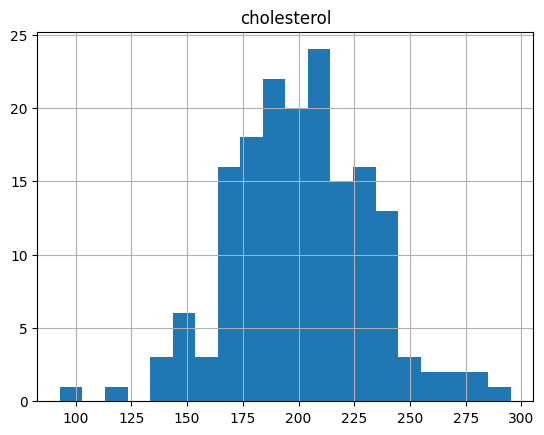

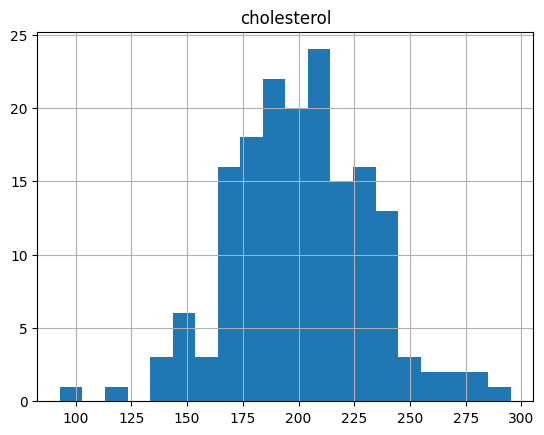

In [15]:
df[['cholesterol']].hist(bins=20)
df_a[['cholesterol']].hist(bins=20)

**Imputation of Missing Cholesterol Values**

Missing cholesterol values were imputed using a hierarchical median strategy:

* Median within combined BMI group × blood pressure group.

* If unavailable, median within BMI group.

* If still unavailable, overall dataset median.

The histograms before and after imputation show nearly identical distributions, indicating that the imputation preserved the original shape and variability of cholesterol values. This reduces the risk of bias due to missing data while maintaining comparability across groups.

**Conclusion:** The hierarchical median imputation is appropriate for this dataset. Subsequent analyses can be performed on the imputed dataset with greater confidence that the missingness has been addressed systematically.